In [19]:
from __future__ import division, print_function
import numpy as np, scipy.stats as st
import matplotlib.pyplot as plt
from collections import OrderedDict
import math
from scipy.optimize import root
import scipy.interpolate

In [20]:
#DDH MODEL WITH SHAPIRO DELAY H3 PARAMETERISATION
x=2.798186
e=0.00004123
omdot_degperyear=1.5804710
omdot_sig = 0.2511040 # FIT FROM DDH 
Pb=0.39188047*24*60*60
#Pbdot = -0.1041430*(10**(-12))   #intrinsic val from ddgr (after adding pbdotexcess)
h3 =0.958538e-6 # for stig 0.8
h3_sig = 0.476284e-6
stig = 0.8
Pbdot_obs = -0.114426*(10**(-12))   #TEMPO 
Pbdot_gal = 0.015476*(10**(-12))
Pbdot_sig = 0.039140*(10**(-12)) #FIT FROM DDH

f = open('results_ddgr_nemodel.dat','r')
#DDGR CALCULATED VALS

mp_ddgr = 1.2638230
mp_ddgr_sig = 0.2386753

mc_ddgr = 1.049374
mc_ddgr_sig =0.143361 

sini_ddgr = 0.8918270
dof = 821

mp=np.arange(0.00001,4,(4-0.00001)/10000)
mc_range=np.arange(0.0,4,(4)/500)
inc_radnew = (np.arange(1e-20,np.pi,np.pi/500))
omdot_degperyear_sig_plus = omdot_degperyear + omdot_sig
omdot_degperyear_sig_minus = omdot_degperyear - omdot_sig
omdot_rad_s=omdot_degperyear*2*np.pi/(360*365*24*60*60)
omdot_rad_s_plus=omdot_degperyear_sig_plus*2*np.pi/(360*365*24*60*60)
omdot_rad_s_minus=omdot_degperyear_sig_minus*2*np.pi/(360*365*24*60*60)
T0=4.925490947e-6
Pbdot = Pbdot_obs - Pbdot_gal
Pbdot_sig_plus = Pbdot + Pbdot_sig
Pbdot_sig_minus = Pbdot - Pbdot_sig

h3_sig_plus = h3+h3_sig
h3_sig_minus = h3-h3_sig



#CALCULATING MTOT FROM OMDOT

Mtot_omdot= (omdot_rad_s*(1-(e*e))*(Pb/(2*np.pi))**(5./3)/(3*T0**(2./3)))**(3./2)

Mtot_plus_omdot= (omdot_rad_s_plus*(1-(e*e))*(Pb/(2*np.pi))**(5./3)/(3*T0**(2./3)))**(3./2)

Mtot_minus_omdot= (omdot_rad_s_minus*(1-(e*e))*(Pb/(2*np.pi))**(5./3)/(3*T0**(2./3)))**(3./2)

#print(Mtot_omdot)

#mc= np.arange(0,3,0.0001)

#fig = plt.figure(figsize=(10,10))

mc_mtot_omdot=Mtot_omdot - mp

mc_mtot_plus_omdot = Mtot_plus_omdot - mp

mc_mtot_minus_omdot = Mtot_minus_omdot - mp

#CALCULATING MC FROM PBDOT

def mc_frompbdot(Pbdot,Pb,e,mp=[]):
    mc_frompbdot = []
    for mp_val in mp:
        fe = (1+((73./24)*e**2)+((37./96)*e**4))/(1-e**2)**(7./2)
        mc_poly_a = (-192*np.pi/5)**3*T0**5*(Pb/(2*np.pi))**(-5)*fe**3*mp_val**3/(Pbdot**3)
        mc_poly_b = 0.0
        mc_poly_c = -1.0
        mc_poly_d = -mp_val
        coeff_mc = [mc_poly_a,mc_poly_b,mc_poly_c,mc_poly_d]
        r = np.real(np.roots(coeff_mc))
        mc_frompbdot.append(r)
    #print("shape of mc: ",np.dtype(mc_frompbdot))
    return mc_frompbdot      

mc_mtot_pbdot = mc_frompbdot(Pbdot,Pb,e,mp)
mc_mtot_pbdot_plus = mc_frompbdot(Pbdot_sig_plus,Pb,e,mp)
mc_mtot_pbdot_minus = mc_frompbdot(Pbdot_sig_minus,Pb,e,mp)


def mc_min_4mpmc(x,Pb,mp=[],mc=[]):
    mc_na=[]
    mp_na=[]
    k=4*np.pi**2*x**3/(T0*Pb**2)
    for m_p in mp:
        mc_na_val = 1e-6
        for m_c in mc:
            sini = (k*(m_p+m_c)**2/m_c**3)**(1./3)
            if sini > 1.0:
                if mc_na_val < m_c:
                    mc_na_val = m_c
        #print("mc_na_val", mc_na_val)
        #print("mp", m_p)
        mc_na.append(mc_na_val)
    return mc_na          
                
mc_na = mc_min_4mpmc(x,Pb,mp,mc_range)


    

#def mc(m,x,Pb,incl_deg):
#    mc_min=[]
#    p0=T0*Pb**2*np.sin(incl_deg*2*np.pi/360)**3
#    p1=-4*np.pi**2*x**3
#    p2=-8*np.pi**2*x**3*m
#    p3=-4*np.pi**2*x**3*m**2
#    coeff = [p0,p1,p2,p3]
#    mc_mi = np.real(np.roots(coeff))
#    mc_min = (mc_mi[mc_mi>0])
    #print(len(mc_min))
#    if len(mc_min)==0:
#        return np.NaN
#    else:
#        return mc_min[0]
    
def mc4negativemp(mc,x,Pb,incl_rad):
    p0=4*np.pi**2*x**3
    p1=8*np.pi**2*x**3*mc
    p2=(4*np.pi**2*x**3*mc**2)-(np.sin(incl_rad)**3*mc**3*T0*Pb**2)
    coeff = [p0,p1,p2]
    mp_mi = np.real(np.roots(coeff))
    check = any(mp_mii > 0 for mp_mii in mp_mi)
    #print(check)
    if check == False:
        #print("Negative value of mp")
        #print("incl_rad")
        #print("sini", np.sin(incl_rad))
        #print("Mp, i, Mc %d %d %d",(mp_mi,np.cos(incl_rad),mc))
        return mc
    else:
        #print(mp_mi)
        c=0
        return c
    
    
def mc4negativemp_new(m_c,x,Pb,incl_rad):
    k = 4*np.pi**2*x**3/(T0*Pb**2)
    if m_c > (np.sqrt((m_c*np.sin(incl_rad))**3/k)):
        return m_c
    else:
        c=0
        return 0
    #print("mp_min", mp_mi)
#mc_minimum=[]
#for m in mp:
#    mc_minimum.append(mc(m,x,Pb,90))

#deg=[5,10,30,50,80]
#for d in deg:
    #mc_minimum_inc=[]
    #for m in mp:
    #    mc_minimum_inc.append(mc_min(m,x,Pb,d))
    #plt.plot(mp,mc_minimum_inc)



min_allowed_mc=[]
mc_sini_omdot=[]
mc_sini_plus_omdot=[]
mc_sini_minus_omdot=[]
mc_sini_pbdot=[]
mc_sini_plus_pbdot=[]
mc_sini_minus_pbdot=[]
mc_sini_h3=[]
mc_sini_plus_h3=[]
mc_sini_minus_h3=[]



#Mtot_pbdot = [sum(j) for j in zip(mc_mtot_pbdot, mp)]
#Mtot_pbdot_plus = [sum(j) for j in zip(mc_mtot_pbdot_plus, mp)]
#Mtot_pbdot_minus = [sum(j) for j in zip(mc_mtot_pbdot_minus, mp)]
for i in inc_radnew:
    mc_notallowed=[]
    mc_sini_omdot.append((4*np.pi**2*x**3*Mtot_omdot**2/(T0*Pb**2))**(1./3)/(np.sin(i)))
    mc_sini_plus_omdot.append((4*np.pi**2*x**3*Mtot_plus_omdot**2/(T0*Pb**2))**(1./3)/(np.sin(i)))
    mc_sini_minus_omdot.append((4*np.pi**2*x**3*Mtot_minus_omdot**2/(T0*Pb**2))**(1./3)/(np.sin(i)))
    
    for m in mc_range:
        mc_notallowed.append(mc4negativemp_new(m,x,Pb,i))
    
    min_allowed_mc.append(np.max(mc_notallowed))

cosinc_pbdot=[]    
for mp_val, mc_val in zip(mp, mc_mtot_pbdot):
    sininc_pbdot = (4*np.pi**2*x**3*(mp_val+mc_val)**2/((T0*Pb**2)*mc_val**3))**(1./3)
    cosinc_pbdot.append(np.sqrt(1-(sininc_pbdot**2)))

cosinc_pbdot_plus=[]    
for mp_val, mc_val in zip(mp, mc_mtot_pbdot_plus):
    sininc_pbdot_plus = (4*np.pi**2*x**3*(mp_val+mc_val)**2/((T0*Pb**2)*mc_val**3))**(1./3)
    cosinc_pbdot_plus.append(np.sqrt(1-(sininc_pbdot_plus**2)))
    
cosinc_pbdot_minus=[]    
for mp_val, mc_val in zip(mp, mc_mtot_pbdot_minus):
    sininc_pbdot_minus = (4*np.pi**2*x**3*(mp_val+mc_val)**2/((T0*Pb**2)*mc_val**3))**(1./3)
    cosinc_pbdot_minus.append(np.sqrt(1-(sininc_pbdot_minus**2)))
    
    

# CALCULATING MC-COSI RELATION FROM H3

# need "many" improvements (just rough for now)
mp_h3 = []
mp_h3_plus = []
mp_h3_minus = []
for i in inc_radnew:
    #k = 4*np.pi**2*x**3/(T0*Pb**2)
    #mc_h3 = (h3/T0)*((1+np.cos(i))/np.sin(i))**3
    
    #mp_h3 = ((mc_h3*np.sin(i))**3/k)**(1./2) - mc_h3
    
    #print("sini", np.sin(i))
    #print("mp_h3", mp_h3)
    
    mc_h3 = (h3/T0)*((1+np.sqrt(1-np.sin(i)**2))/np.sin(i))**3
    mc_h3_plus = (h3_sig_plus/T0)*((1+np.sqrt(1-np.sin(i)**2))/np.sin(i))**3
    mc_h3_minus = (h3_sig_minus/T0)*((1+np.sqrt(1-np.sin(i)**2))/np.sin(i))**3
    mc_sini_h3.append(mc_h3)
    mc_sini_plus_h3.append(mc_h3_plus)
    mc_sini_minus_h3.append(mc_h3_minus)
    mp_h3_val = np.sqrt(T0*Pb**2*(mc_h3*np.sin(i))**3/(4*np.pi**2*x**3)) - mc_h3
    mp_h3_val_plus = np.sqrt(T0*Pb**2*(mc_h3_plus*np.sin(i))**3/(4*np.pi**2*x**3)) - mc_h3_plus
    mp_h3_val_minus = np.sqrt(T0*Pb**2*(mc_h3_minus*np.sin(i))**3/(4*np.pi**2*x**3)) - mc_h3_minus
    #print("Sin i", np.sin(i))
    #print("mp_h3_val_minus",mp_h3_val_minus)
    mp_h3.append(mp_h3_val)
    mp_h3_plus.append(mp_h3_val_plus)
    mp_h3_minus.append(mp_h3_val_minus)


def c_fromstig(stig,mp=[]):
    mc_fromstig = []
    inc_poly_a = (stig**2)+1
    inc_poly_b = 2*stig**2
    inc_poly_c = (stig**2)-1
    coeff_inc = [inc_poly_a,inc_poly_b,inc_poly_c]
    cosi = np.real(np.roots(coeff_inc))
    for c in cosi:
        if 0<c<1:
            cosi_stig = c
    
    #for mp_val in mp:
    #    mc_frompbdot.append(r)
    #print("shape of mc: ",np.dtype(mc_frompbdot))
    return cosi_stig     

cosi_stig = Cc_fromstig(stig,mp)
#mc_mtot_pbdot_plus = mc_frompbdot(Pbdot_sig_plus,Pb,e,mp)
#mc_mtot_pbdot_minus = mc_frompbdot(Pbdot_sig_minus,Pb,e,mp)
print("COSI VAL FROM STIG IS: ", cosi_stig)


#overplotting chi2 contour


next(f)
#next(f_ymw)
lines=f.readlines()
cosi=[]
m2=[]
chi2=[]
m1=[]
for l in lines:
    cosi.append(float(l.split(' ')[1]))
    m2.append(float(l.split(' ')[2]))
    chi2.append(dof*float(l.split(' ')[4]))
    m1.append(float(l.split(' ')[3]))
    
N = 1000 #number of points for plotting/interpolation

M1 = np.linspace(min(m1),max(m1),N)
COSI = np.linspace(min(cosi), max(cosi), N)
M2 = np.linspace(min(m2), max(m2), N)
#CHI2 = scipy.interpolate.griddata((cosi, m2), chi2, (COSI[None,:], M2[:,None]), method='cubic')

chi2_min = min(chi2)

delta_chi2=[]
for chi in chi2:
    delta_chi2.append(chi - chi2_min)

likelihood=[]
[likelihood.append(0.5*np.exp(-dchi2/2)) for dchi2 in delta_chi2]
PDF = scipy.interpolate.griddata((cosi, m2), likelihood, (COSI[None,:], M2[:,None]), method='cubic')
PDF_m1 = scipy.interpolate.griddata((m1, m2), likelihood, (M1[None,:], M2[:,None]), method='cubic')

#print("PDF_m1:", PDF_m1)

tot_vol = 0.0
for i,j in enumerate(M2):
    for k,l in enumerate(COSI):
        if PDF[k][i] > 0.0:
            tot_vol = tot_vol + PDF[k][i]
#print("tot_vol", tot_vol)

tot_vol_m1 = 0.0
for i,j in enumerate(M2):
    for k,l in enumerate(M1):
        if PDF_m1[k][i] > 0.0:
            tot_vol_m1 = tot_vol_m1 + PDF_m1[k][i]
#print("tot_vol_m1", tot_vol_m1)

pdf_nans = np.isnan(PDF)
PDF[pdf_nans] = 0.0

pdf_m1_nans = np.isnan(PDF_m1)
PDF_m1[pdf_m1_nans] = 0.0




def level_contour(sig,tot_vol,pdf,Y,X):
    pdf_var = 0.0
    pdf_vol = tot_vol/2
    vol=0.0
    eps = 0.1
    grnd_pdf_var = 0.0
    upper_pdf_var = np.max(pdf)
    c = 0.0
    while vol != 0.68*tot_vol and vol != 0.95*tot_vol:
        vol = 0.0
        for i,j in enumerate(Y):
            min_cosi = 0.1
            for k,l in enumerate(X):         
                if pdf[k][i] > pdf_var:
                    vol = vol + pdf[k][i]
        #print(vol)
        if np.abs(vol - (sig*tot_vol)) > eps:
            if vol > sig*tot_vol:
                grnd_pdf_var = pdf_var
                c = ( upper_pdf_var + grnd_pdf_var )/2
                pdf_var = c
                #print("no go up")
                #print(vol)
                #print("newpdfvar", pdf_var)
            elif vol < (sig*tot_vol):
                upper_pdf_var = pdf_var
                c = ( upper_pdf_var + grnd_pdf_var )/2
                pdf_var = c
                #print("no go down")
                #print(vol)
                #print("newpdfvar", pdf_var)
        elif np.abs(vol - sig*tot_vol) < eps:
            #print("YES")
            #print(vol)
            tot_vol_1sig = vol
            sig_pdf=pdf_var
            break
    return sig_pdf

onesig_pdf = level_contour(0.68,tot_vol,PDF,M2,COSI)
twosig_pdf = level_contour(0.95,tot_vol,PDF,M2,COSI)

onesig_pdf_m1 = level_contour(0.68,tot_vol_m1,PDF_m1,M2,M1)
twosig_pdf_m1 = level_contour(0.95,tot_vol_m1,PDF_m1,M2,M1)
#onesig_pdf_m1 = level_contour(0.68,tot_vol_m1,PDF_m1,M2,M1)
print("1sigma m2-cosi contour at", onesig_pdf)
print("2sigma m2-cosi contour at", twosig_pdf)
#print("volume of pdf", tot_vol_1sig)

print("1sigma m2-m1 contour at", onesig_pdf_m1)
print("2sigma m2-m1 contour at", twosig_pdf_m1)




/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in double_scalars
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in power
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in sqrt
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: invalid value encountered in power
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in sqrt
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in power
/home/imprs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in sqrt


COSI VAL FROM STIG IS:  0.21951219512195108
1sigma m2-cosi contour at 0.20966677635969433
2sigma m2-cosi contour at 0.04320178764666721
1sigma m2-m1 contour at 0.20503846653897428
2sigma m2-m1 contour at 0.041535709107658636


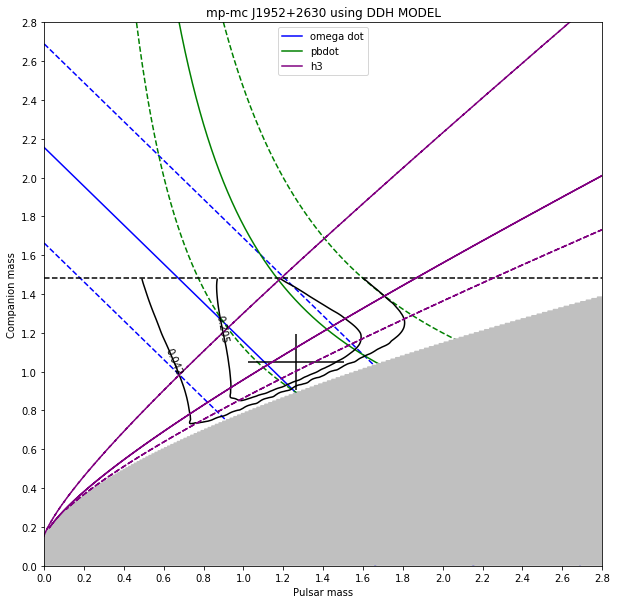

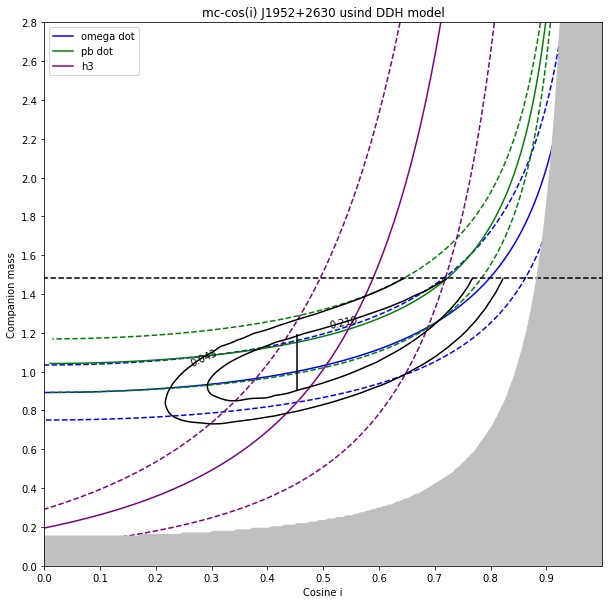

In [21]:
fig = plt.figure(figsize=(10,10))
plt.title("mp-mc J1952+2630 using DDH MODEL")
plt.xlabel("Pulsar mass")
plt.ylabel("Companion mass")
plt.xlim(0,4)
plt.ylim(0,4)
plt.xticks(np.arange(0, 4, step=0.2))
plt.yticks(np.arange(0, 4, step=0.2))
plt.plot(mp,mc_mtot_omdot,zorder=1,color='blue',label='omega dot')
plt.plot(mp,mc_mtot_plus_omdot,'--',zorder=1,color='blue')
plt.plot(mp,mc_mtot_minus_omdot,'--',zorder=1,color='blue')

plt.plot(mp,mc_mtot_pbdot,zorder=1,color='green',label='pbdot')
plt.plot(mp,mc_mtot_pbdot_plus,'--',zorder=1,color='green',label=None)
plt.plot(mp,mc_mtot_pbdot_minus,'--',zorder=1,color='green',label=None)
plt.plot(mp,mc_na,color='silver')
#plt.plot(mp,mc_minimum,color='silver')
plt.fill_between(mp, 0, mc_na,facecolor='silver',zorder=2)
plt.plot(mp_h3,mc_sini_h3,zorder=2,color='purple',label='h3')
plt.plot(mp_h3_plus,mc_sini_plus_h3,'--',zorder=2,color='purple',label=None)
plt.plot(mp_h3_minus,mc_sini_minus_h3,'--',zorder=2,color='purple',label=None)

plt.errorbar(mp_ddgr,mc_ddgr,xerr=mp_ddgr_sig, yerr=mc_ddgr_sig, errorevery=1, color='black',markeredgewidth=20)
plt.hlines(1.48, np.min(mp),np.max(mp),linestyles='--', color ='black')

levels_m1 = [twosig_pdf_m1,onesig_pdf_m1]


cp_m1 = plt.contour(M1, M2, PDF_m1, levels_m1, colors = 'black')
plt.clabel(cp_m1, inline=False, 
         fontsize=10)

#levels_m1_ymw = [twosig_pdf_m1_ymw,onesig_pdf_m1_ymw]


#cp_m1_ymw = plt.contour(M1_ymw, M2_ymw, PDF_m1_ymw, levels_m1_ymw, colors = 'red')
#plt.clabel(cp_m1_ymw, inline=False, 
#          fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlim(0,2.8)
plt.ylim(0,2.8)
plt.savefig("mc-mp-1952-ddh.png", format='png')

plt.show()

plt.close()

    
fig = plt.figure(figsize=(10,10))
plt.title("mc-cos(i) J1952+2630 usind DDH model")
plt.xlabel("Cosine i")
plt.ylabel("Companion mass")
plt.xlim(0,1)
plt.ylim(0,4)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 4, step=0.2))
plt.plot(np.cos(inc_radnew),mc_sini_omdot,zorder=1,color='blue',label='omega dot')
plt.plot(np.cos(inc_radnew),mc_sini_plus_omdot,'--',color='blue',zorder=1)
plt.plot(np.cos(inc_radnew),mc_sini_minus_omdot,'--',color='blue',zorder=1)

plt.plot(cosinc_pbdot,mc_mtot_pbdot,zorder=1,color='green',label='pb dot')
plt.plot(cosinc_pbdot_plus,mc_mtot_pbdot_plus,'--',zorder=1,color='green')
plt.plot(cosinc_pbdot_minus,mc_mtot_pbdot_minus,'--',zorder=1,color='green')

plt.plot(np.cos(inc_radnew),mc_sini_h3,zorder=1,color='purple',label='h3')
plt.plot(np.cos(inc_radnew),mc_sini_plus_h3,'--',color='purple',zorder=1)
plt.plot(np.cos(inc_radnew),mc_sini_minus_h3,'--',color='purple',zorder=1)


plt.plot(np.cos(inc_radnew),min_allowed_mc,color='silver',zorder=2)
plt.fill_between(np.cos(inc_radnew), 0, min_allowed_mc,facecolor='silver',zorder=2)

plt.errorbar(np.sqrt(1-sini_ddgr**2),mc_ddgr,xerr=None, yerr=mc_ddgr_sig, errorevery=1, color='black',markeredgewidth=20)
plt.hlines(1.48, np.min(np.cos(inc_radnew)),np.max(np.cos(inc_radnew)),linestyles='--', color ='black')

levels = [twosig_pdf,onesig_pdf]


cp = plt.contour(COSI, M2, PDF, levels, colors = 'black')
plt.clabel(cp, inline=False, 
          fontsize=10)

#levels_ymw = [twosig_pdf_ymw,onesig_pdf_ymw]


#cp_ymw = plt.contour(COSI_ymw, M2_ymw, PDF_ymw, levels_ymw, colors = 'red')
#plt.clabel(cp_ymw, inline=False, 
#          fontsize=10)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0,2.8)
plt.savefig("mc-cosi-1952-ddh.png", format='png')

plt.show()

plt.close()